# <span style="color:#FF8800"> Load data & generate features

In [2]:
import os
import pandas as pd
import spacy

In [4]:
train_df = pd.read_csv("datasets/train_data.tsv", 
                       sep = "\t",
                       usecols = ["label","label_binary","text"]
                      )

In [5]:
print(train_df.shape)
train_df.sample(3)

(15928, 3)


,label,label_binary,text
2536,No_Propaganda,No_Propaganda,the 69-year-old Jewish man (wearing a kippah o...
2396,Thought-terminating_Cliches,Propaganda,It is over
3176,No_Propaganda,No_Propaganda,Politician?\nWhom do you consider to be the mo...


> ### The training data, which was created in generate_data.ipynb, contains +15,900 samples with binary and multi-class labels. Here we'll focus on multi-class classification.

In [7]:
import textstat

In [10]:
train_df["sent_count"] = train_df.apply(lambda x: textstat.sentence_count(x["text"]), axis = 1) # number of sentences in span
train_df["flesch_reading"] = train_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis = 1) # Flesch reading ease score, higher is easier to read
train_df["difficult_words"] = train_df.apply(lambda x: textstat.difficult_words(x["text"]), axis = 1) # count of words with 2 or more syllables, seems like low threshold
train_df["read_index"] = train_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis = 1) # approximates the grade level needed to comprehend the text
train_df["syllable_count"] = train_df.apply(lambda x: textstat.syllable_count(x["text"]), axis = 1) # count of the number of syllables in the given text
train_df["text_standard"] = train_df.apply(lambda x: textstat.text_standard(x["text"], float_output = True), axis = 1) # combines a number of readability scores, the estimated school grade level to understand text
train_df["text_len"] = train_df.apply(lambda x: len(x["text"]), axis=1) # the length of the text

In [11]:
text_stats = round(train_df.groupby("label_binary").mean(),1)
text_stats.T

label_binary,No_Propaganda,Propaganda
sent_count,1.2,1.1
flesch_reading,67.2,44.5
difficult_words,3.2,2.2
read_index,8.3,10.7
syllable_count,18.8,12.6
text_standard,7.8,7.9
text_len,75.0,48.3


> ### Based on research into related work it appears that creating some linguistic features from the sample text may help with the classification task.
> ### <span style="color:#8800ff"> In fact, we can see that texts featuring propaganda are shorter (text_len), more difficult to read (flesch_reading, lower is harder to understand), and contain fewer syllables (syllable_count) than texts without propaganda.

In [17]:
feature_cols = ['text', 'sent_count', 'flesch_reading',
                'difficult_words', 'read_index', 'syllable_count',
                'text_standard','text_len']

# <span style="color:#FF8800"> Train test split

In [15]:
from sklearn.model_selection import train_test_split

In [24]:
X_train, X_test, y_train, y_test = train_test_split(
    train_df[feature_cols], 
    train_df["label"], 
    train_size = 0.7, 
    random_state = 3, 
    shuffle = True, 
    stratify = train_df["label"])

> ### Here we're creating a training and testing split from just the training data so we can perform grid search and tune the hyperparameters.

> ### We're using a standard 70-30 train-test split, shuffling the samples, and stratifying the samples so the training and testing data contain similar proportions of the labels.

# <span style="color:#FF8800"> Transform features

In [21]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [22]:
word_vectorizer = TfidfVectorizer(
    strip_accents = "unicode", 
    lowercase = True,
    stop_words = "english", 
    analyzer = "word", 
    token_pattern = "[a-z]+", 
    smooth_idf = True, 
    ngram_range=(1,3)
)

> ### I want to create a tf-idf statistic based on the text in the samples in order to utilize insights related to how informative words are based on how frequently they are used 1) in the corpus overall and 2) in a particular sample.
> ### TfidfVectorizer will generate a sparse matrix.
> ### I'm employing smoothing so each token is counted at least once in the vocabulary. This is more relevant when we apply the tfidf matrix created here to the testing data we split out earlier.

In [23]:
from sklearn.compose import ColumnTransformer

In [9]:
column_trans = ColumnTransformer([('tfidf', word_vectorizer, 'text')], remainder="passthrough")

# train_transformed = column_trans.fit_transform(X_train)
# test_transformed = column_trans.transform(X_test) #must use same transform call for dev data


train_transformed = column_trans.fit_transform(train_df[feature_cols])
# test_transformed = column_trans.transform(train_df[feature_cols]) #must use same transform call for dev data

In [10]:
from sklearn.linear_model import LogisticRegression

In [11]:
best_lr = LogisticRegression(C=10000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=234, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [12]:
# best_lr.fit(train_transformed, train_df["label_binary"])
best_lr.fit(train_transformed, train_df["label"])

/home/bryan/Documents/Code/python-environments/SI630/lib/python3.6/site-packages/sklearn/linear_model/_logistic.py:1539: UserWarning: 'n_jobs' > 1 does not have any effect when 'solver' is set to 'liblinear'. Got 'n_jobs' = 8.
  " = {}.".format(effective_n_jobs(self.n_jobs)))


LogisticRegression(C=10000, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=-1, penalty='l2',
                   random_state=234, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)

In [13]:
# load dev data
dev_df = pd.read_csv("dev_data.tsv", 
                       sep = "\t",
                       usecols = ["label","label_binary","text"]
                      )

In [14]:
print(dev_df.shape)
dev_df.sample(3)

(2850, 3)


,label,label_binary,text
1353,No_Propaganda,No_Propaganda,Trump of high treason against the United State...
94,No_Propaganda,No_Propaganda,Craig Roberts Best Price: $11.96 Buy New $19.3...
1352,No_Propaganda,No_Propaganda,they feel safe and trust the connections they ...


In [15]:
# Add features

import textstat

dev_df["sent_count"] = dev_df.apply(lambda x: textstat.sentence_count(x["text"]), axis=1)
dev_df["flesch_reading"] = dev_df.apply(lambda x: textstat.flesch_reading_ease(x["text"]), axis=1)
dev_df["difficult_words"] = dev_df.apply(lambda x: textstat.difficult_words(x["text"]), axis=1)
dev_df["read_index"] = dev_df.apply(lambda x: textstat.automated_readability_index(x["text"]), axis=1)
dev_df["syllable_count"] = dev_df.apply(lambda x: textstat.syllable_count(x["text"]), axis=1)
dev_df["text_standard"] = dev_df.apply(lambda x: textstat.text_standard(x["text"], float_output=True), axis=1)

dev_df["text_len"] = dev_df.apply(lambda x: len(x["text"]), axis=1)

In [16]:
dev_transformed = column_trans.transform(dev_df[feature_cols]) #must use same transform call for dev data

In [17]:
lr_y_pred = best_lr.predict(dev_transformed)

In [18]:
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

In [19]:
labels = list(best_lr.classes_)
# cm = confusion_matrix(dev_df["label_binary"], lr_y_pred, labels)
cm = confusion_matrix(dev_df["label"], lr_y_pred, labels)

In [33]:
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / np.sum(cm).astype('float')
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(20, 10))
#     plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=90)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
#     plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.xlabel('Predicted label')
    plt.savefig('LR_confusion_mat.png')
    plt.show()

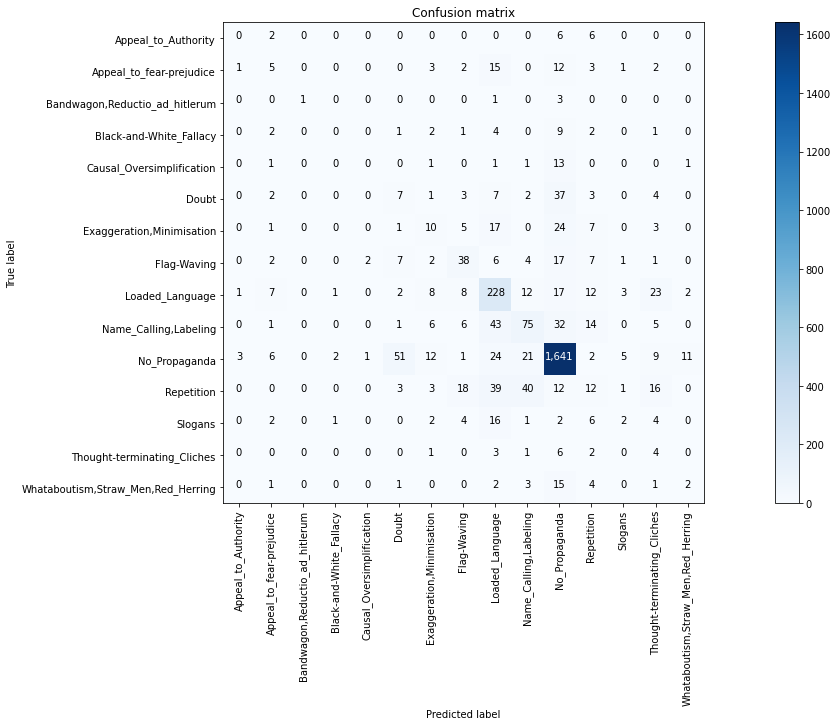

In [34]:
plot_confusion_matrix(cm = cm, target_names = labels, normalize = False)

In [22]:
from sklearn.metrics import classification_report

In [24]:
print(classification_report(dev_df["label"], lr_y_pred, target_names=labels))
# print(classification_report(dev_df["label_binary"], lr_y_pred, target_names=labels))

                                    precision    recall  f1-score   support

               Appeal_to_Authority       0.00      0.00      0.00        14
          Appeal_to_fear-prejudice       0.16      0.11      0.13        44
    Bandwagon,Reductio_ad_hitlerum       1.00      0.20      0.33         5
           Black-and-White_Fallacy       0.00      0.00      0.00        22
         Causal_Oversimplification       0.00      0.00      0.00        18
                             Doubt       0.09      0.11      0.10        66
         Exaggeration,Minimisation       0.20      0.15      0.17        68
                       Flag-Waving       0.44      0.44      0.44        87
                   Loaded_Language       0.56      0.70      0.62       324
             Name_Calling,Labeling       0.47      0.41      0.44       183
                     No_Propaganda       0.89      0.92      0.90      1789
                        Repetition       0.15      0.08      0.11       144
           

In [ ]:
from sklearn.metrics import f1_score
f1_score(dev_df["label"], lr_y_pred, average='micro') #semeval uses micro F1

In [ ]:
# flat_true_labels, flat_predictions
flat_true_labels = [0,1,1,0]

In [ ]:
[x for x in flat_true_labels]

In [ ]:
flat_true_labels = ["Propaganda" if x == 1 else "No_Propaganda" for x in flat_true_labels]
also = ["Propaganda" if x == 1 else "No_Propaganda" for x in flat_true_labels]

In [ ]:
this_df = pd.DataFrame({"true_labels":flat_true_labels,"predicted_labels":also}, columns=["true_labels","predicted_labels"])
this_df.to_csv("testing.csv", index=False)